<a href="https://colab.research.google.com/github/AdamAnderB/Bramlett_DSPN_S24/blob/main/final_project_Bramlett.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Learning Mechanisms of Second Language Speech Cues
## Harnessing Prediction-Error from Eye-Fixations to Understand and Enhance Learning

### INTRODUCTION
This project investigates the cognitive processes underlying second language speech learning at and below the level of the word. Second language speech learning is challenging, with even advanced learners struggling with new features in a second language (e.g., tones, affricates, pharyngeals, stops). Despite extensive resources dedicated to increasing students' exposure to these contrasts, recent work in second language acquisition suggests that exposure alone may not suffice. Prediction-error/surprisal may be necessary for the successful learning of new speech sounds and words. This research began with a pilot replication of Nixon's (2020) seminal study on the role of surprisal in learning Southern-Min tones. Our pilot study replicated and methodologically extended Nixon's findings by measuring surprisal as a function of relative looks to targets and competitors during training to predict learning outcomes during testing. The proposed study aims to continue this line of research by first expanding the application of surprisal in learning across a broader linguistic spectrum (e.g., Mandarin-affricates).

In Nixon(2020)'s second experiement participants were placed into 1 of 2 training conditions (cue-outcome or outcome-cue). That is, learners either heard a word followed by a referent or saw a referent followed by a oral word. Crucially, however, the frequency of the high and low frequency items remain constant across both conditions. That is, the experimental manipulation (sound-first or image-first) is used to either elicit prediction-error or to avoid it. In Nixon(2020) the testing results after this training is then compared between groups. Nixon shows that both groups do better on the high frequency items. However, in the critical interaction between presentation order and frequency, low frequency items were learned better in the sound-first condition. This indicates that prediction-error rather than raw frequency may be the primary reason for learning. It is important to note that in this experiment high accuracy for high frequency items does not suggest learning. This is because the critical sound contrast is between low and high frequency items. Said another way, only performance on the low frequency items implies learning.

However, this experimental manipulation assumes that the ordering does indeed elict prediction error. That is, the outcomes of Nixon(2020) are based solely on the testing outcomes and no data during training is collected. Here,


### OBJECTIVES
- **Experiment 1:**
  - Replicate and broaden the scope of Nixon's (2020) findings on error-driven learning.
  - Implement a novel web-based eye-tracking methodology for quantifying prediction-error during language training, facilitating direct comparisons with test results.

### METHODOLOGY
- **Experiment 1:**
  - **Speech Training:** Elicits surprisal or not (experimental manipulation) for words in Mandarin-affricates, Arabic-pharyngeals, and Korean-stops. Web-gazer-based to enable the capturing of surprisal during training.
  - **Post-test:** Examines learning accuracy of phonological contrasts in words.

### PARTICIPANTS
Results from power analysis require that both experiment require closer to 30 participants if we are collecting 12 measurements per item. The tasks from both experiments take approximately 40 minutes to complete, with each participant receiving $10 payment. However, funding limitations have restricted current data collection only to 20 participants total. After more funding is acquired, more data will be collected. However, even at current state, power is currently at 70% suggesting that while under powered for the standard minimum of 80% it will definitely be properly powered once 10 more participants are collected.

### SIGNIFICANCE
By shedding light on error-driven learning mechanisms within second language acquisition, this research aspires to reshape language teaching/learning methodologies. It promises to provide insights into the cognitive processes fueling language learning, potentially transforming educational practices.



In [2]:
#install.packages("lme4")
library(lme4)
require(tidyverse)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘minqa’, ‘nloptr’, ‘Rcpp’, ‘RcppEigen’


Loading required package: Matrix

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()   masks base::%||%()
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


,subject,condition,block,item,block_condition,outcome
,<int>,<fct>,<fct>,<int>,<chr>,<int>
1,1,low_frequency,1,1,sound_first,1
2,1,low_frequency,1,1,sound_first,1
3,1,low_frequency,1,1,sound_first,1
4,1,low_frequency,1,1,sound_first,1
5,1,low_frequency,1,1,sound_first,1
6,1,low_frequency,1,1,sound_first,1
7,1,high_frequency,1,2,sound_first,1
8,1,high_frequency,1,2,sound_first,1
9,1,high_frequency,1,2,sound_first,1


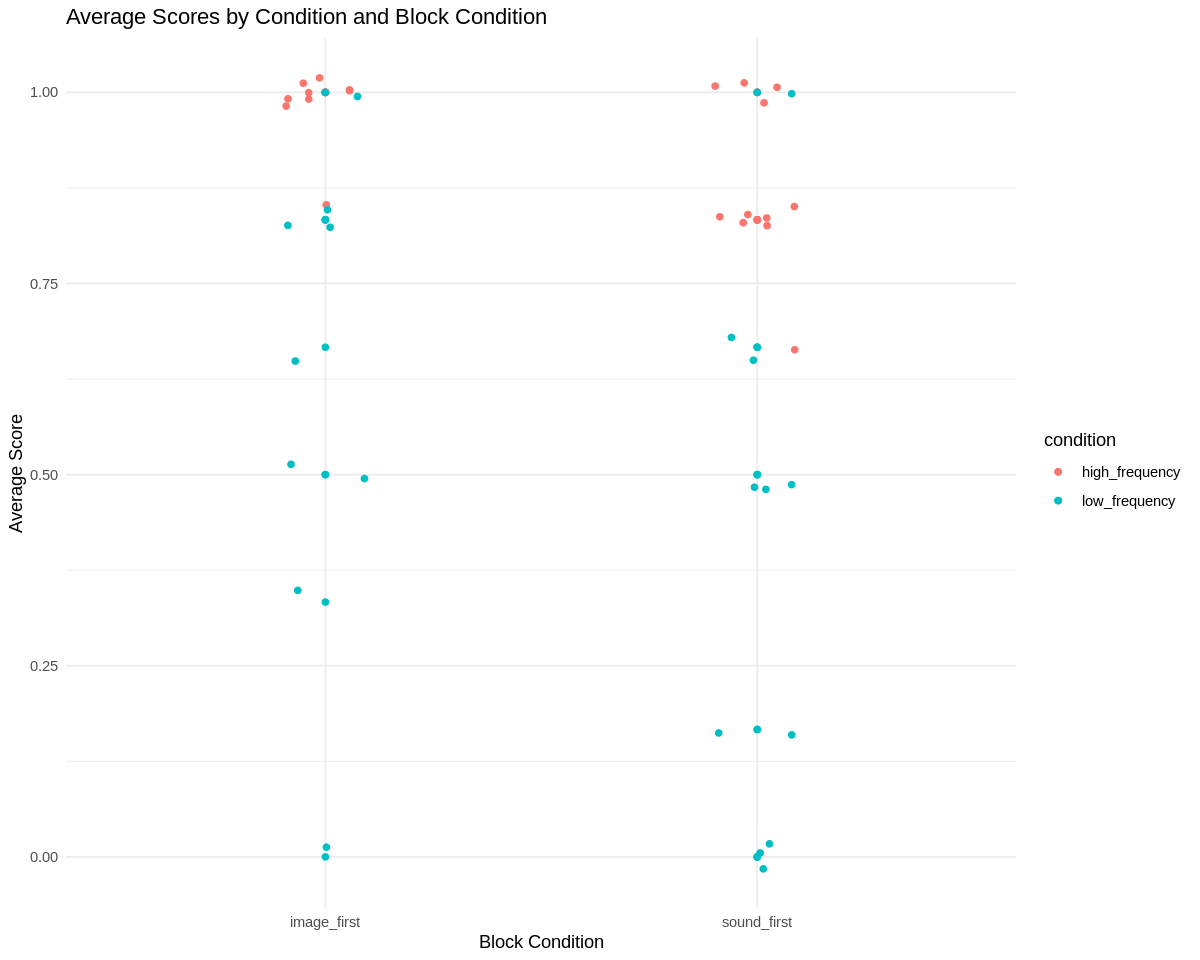

In [19]:
simulate_data <- function(n_subjects, items_per_condition, trials_per_item, blocks,
                          p_high, p_low, bonus_sound_first) {
    subjects <- rep(1:n_subjects, each = items_per_condition * trials_per_item * blocks * 2)
    condition <- rep(rep(c("low_frequency", "high_frequency"), each = trials_per_item * items_per_condition), times = blocks * n_subjects)
    block <- rep(rep(1:blocks, each = trials_per_item * items_per_condition * 2), times = n_subjects)
    item <- rep(rep(1:(items_per_condition * 2), each = trials_per_item), times = blocks * n_subjects)

    # Assigning block conditions (Image first or Sound first)
    block_condition <- rep(sample(c("image_first", "sound_first"), n_subjects, replace = TRUE), each = items_per_condition * trials_per_item * blocks * 2)

    # Adding subject-specific random effects
    subject_effect_high <- rnorm(n_subjects, 0, 0.04)  # Normal distribution for high frequency
    subject_effect_low <- rnorm(n_subjects, 0, .4)   # Normal distribution for low frequency

    # Adjusting probabilities for Sound first condition and including subject-specific noise
    adjusted_p_high <- pmin(pmax(0, ifelse(block_condition == "sound_first",
                                p_high + bonus_sound_first + subject_effect_high[subjects],
                                p_high + subject_effect_high[subjects])), 1)
    adjusted_p_low <- pmin(pmax(0, ifelse(block_condition == "sound_first",
                               p_low + bonus_sound_first + subject_effect_low[subjects],
                               p_low + subject_effect_low[subjects])), 1)

    # Simulating correct/incorrect outcomes based on probabilities
    outcome <- ifelse(condition == "high_frequency",
                      rbinom(length(condition), 1, adjusted_p_high),
                      rbinom(length(condition), 1, adjusted_p_low))

    dat <- data.frame(subject = subjects, condition = condition, block = block,
                      item = item, block_condition = block_condition, outcome = outcome)
    dat<-dat%>%
      mutate(condition=as.factor(condition),
             block=as.factor(block))

    return(dat)
}

set.seed(08)
dat <- simulate_data(n_subjects = 20, items_per_condition = 1, trials_per_item = 6,
                     blocks = 1, p_high = 0.95, p_low = 0.4, bonus_sound_first = 0.001)
head(dat, n = 10)
agg_dat <- dat %>%
  group_by(block_condition, condition,subject) %>%
  summarize(score = mean(outcome), .groups = 'drop')

ggplot(agg_dat, aes(x = block_condition, y = score, color = condition)) +
  geom_jitter(width = 0.1, height = 0.02) +
  geom_point(stat = "identity") +
  labs(title = "Average Scores by Condition and Block Condition",
       x = "Block Condition",
       y = "Average Score")+
       theme_minimal()


In [13]:

#install.packages("lme4", type = "source")
# a function for running a mixed-model and extracting coverage, theta_bias, sigma_bias, and p-values.
run_analysis <- function(data) {
    # Fit null and alternative model
    m0 <- glmer(outcome ~ 1 + (1|subject), data=data,family = "binomial") # null model
    m1 <- glmer(outcome ~ condition * block_condition + (1 |subject), data=data,family = "binomial")

    # Extract estimate and standard error for the interaction term
    est <- fixef(m1)[4]
    se <- summary(m1)$coef[, 2, drop = FALSE][4]
    # BIC calculation to compare models
    m_bic <- BIC(m0, m1)$BIC
    statistic <- diff(m_bic)
    return(c(est, se, statistic))
}

#check to ensure model is running properly
#m1 <- glmer(outcome ~ condition * block_condition + (1 |subject), data=dat, ,family = "binomial")
#summary(m1)$coef
#a<-run_analysis(dat)
#a

repeat_analysis <- function(n_simulations, n_subjects, items_per_condition, trials_per_item, blocks, p_high, p_low, bonus_sound_first) {
    simouts <- matrix(rep(NA, 3 * n_simulations), nrow = n_simulations)
    error_count <- 0 # Track number of errors

    # Loop for repeating the simulation
    for (i in 1:n_simulations) {
        tryCatch({
            data <- simulate_data(n_subjects, items_per_condition, trials_per_item, blocks, p_high, p_low, bonus_sound_first)
            analysis_results <- run_analysis(data)
            simouts[i,] <- analysis_results # Save the analysis outputs for this simulation.
        }, error = function(e) {
            error_count <- error_count + 1
            warning(paste("Error in simulation", i, ":", e$message))
        })
    }

    if (error_count == n_simulations) {
        stop("All simulations failed. Check model and data simulation parameters.")
    }

    # Calculate statistics only for successful simulations
    valid_simouts <- simouts[complete.cases(simouts), ]
    power <- mean(valid_simouts[,3] <= -20) # -20 as a significant threshold
    estimated_slope <- mean(valid_simouts[,1])
    theta_bias <- (estimated_slope - bonus_sound_first) / bonus_sound_first
    sigma_bias <- (mean(valid_simouts[,2]) - sd(valid_simouts[,1])) / sd(valid_simouts[,1])

    return(list(power = power, theta_bias = theta_bias, sigma_bias = sigma_bias))
}

#check repeat analysis function
#repeat_analysis(n_simulations=2, n_subjects = 20, items_per_condition = 3, trials_per_item = 12,
#                     blocks = 1, p_high = 0.9, p_low = 0.4, bonus_sound_first = 0.001)


In [21]:
#warning this takes a long time. If you are on a limited colab plan-run locally.
dat <- expand.grid(n_subjects = c(8,10,12,14,16,18,20), items_per_condition = 1, trials_per_item = c(8,10,12),
                     blocks = 1, p_high = 0.95, p_low = 0.4, bonus_sound_first = 0.001)
dat$id <- 1:nrow(dat)
# then use tidyverse functions
results <- dat %>%
    nest(parameters :=  c(n_subjects, trials_per_item)) %>%
    mutate(
        analysis_results = map(parameters, ~repeat_analysis(n_simulations=50,
                                                            n_subjects = .$n_subjects,
                                                            items_per_condition = 1,
                                                            trials_per_item = .$trials_per_item,
                                                            blocks = 1,
                                                            p_high = 0.95,
                                                            p_low = 0.7,
                                                            bonus_sound_first = 0.001)),
        power = map_dbl(analysis_results, ~.x$power),
        theta_bias = map_dbl(analysis_results, ~.x$theta_bias),
        sigma_bias = map_dbl(analysis_results, ~.x$sigma_bias)
    ) %>%
    select(-analysis_results) %>%
    unnest(c(parameters, power, theta_bias, sigma_bias))

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

Warning message:
“There were 595 warnings in `mutate()`.
The first warning was:
ℹ In argument: `analysis_results = map(...)`.
Caused by warning in `checkConv()`:
! unable to evaluate scaled gradient
ℹ Run `dplyr::last_dplyr_warnings()` to see the 594 remaining warnings.”


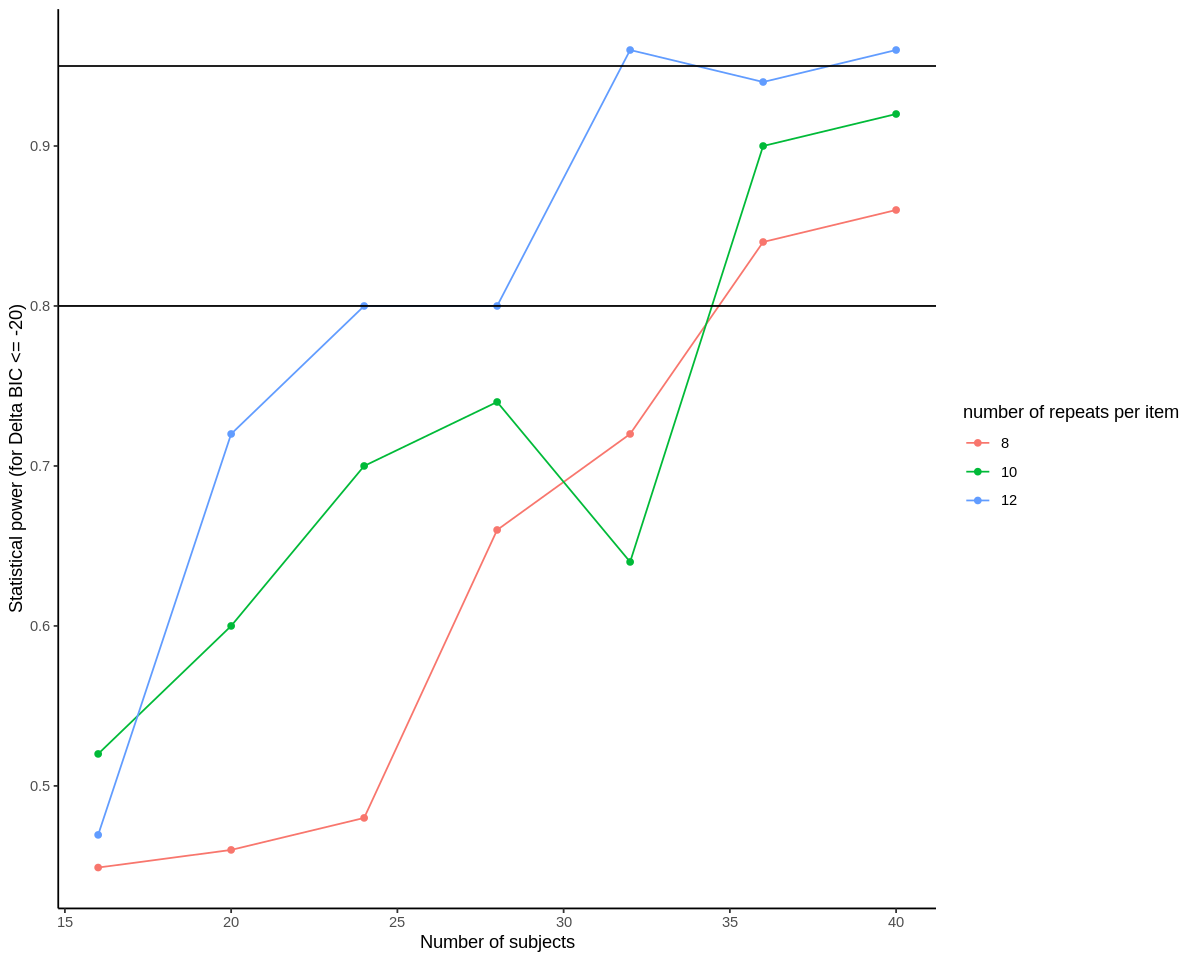

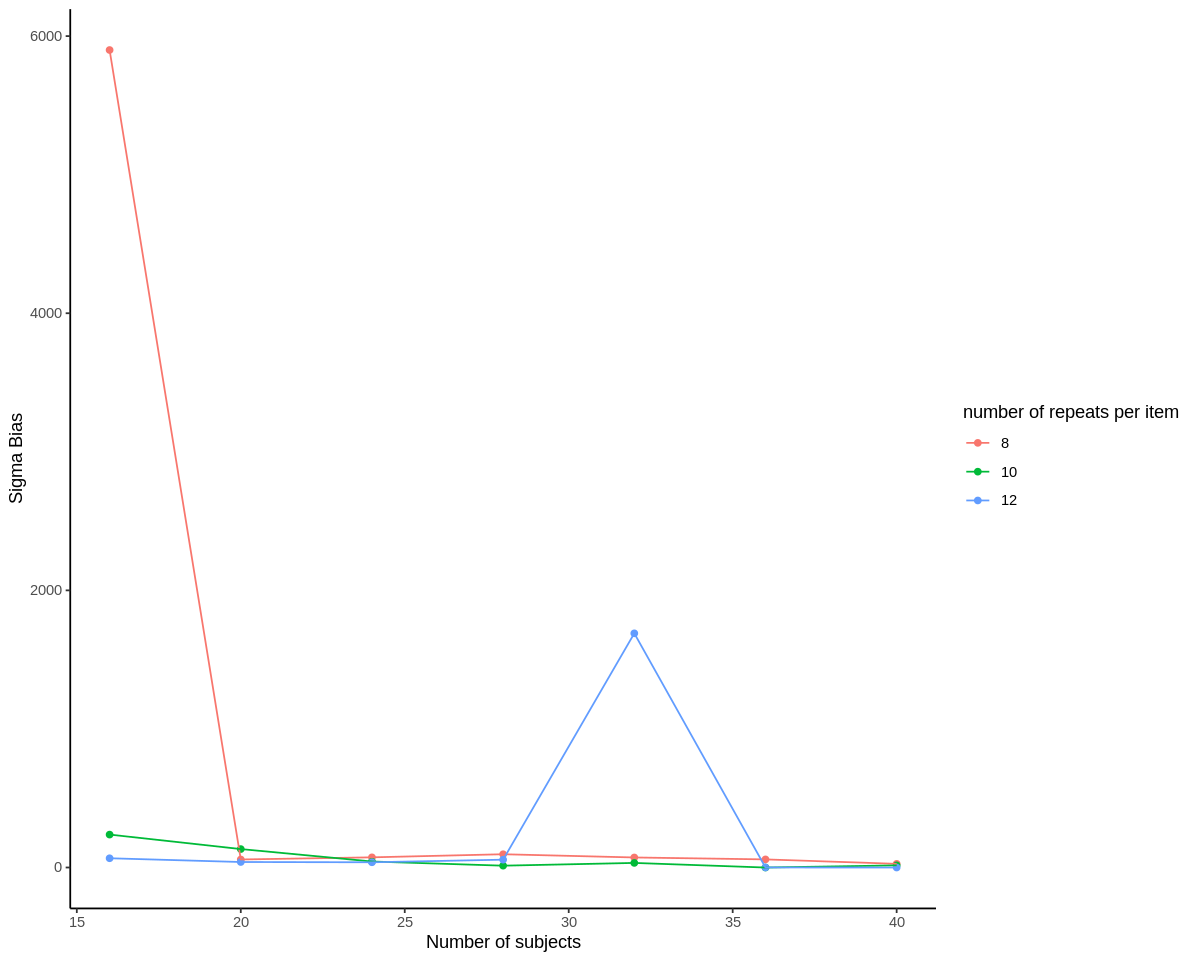

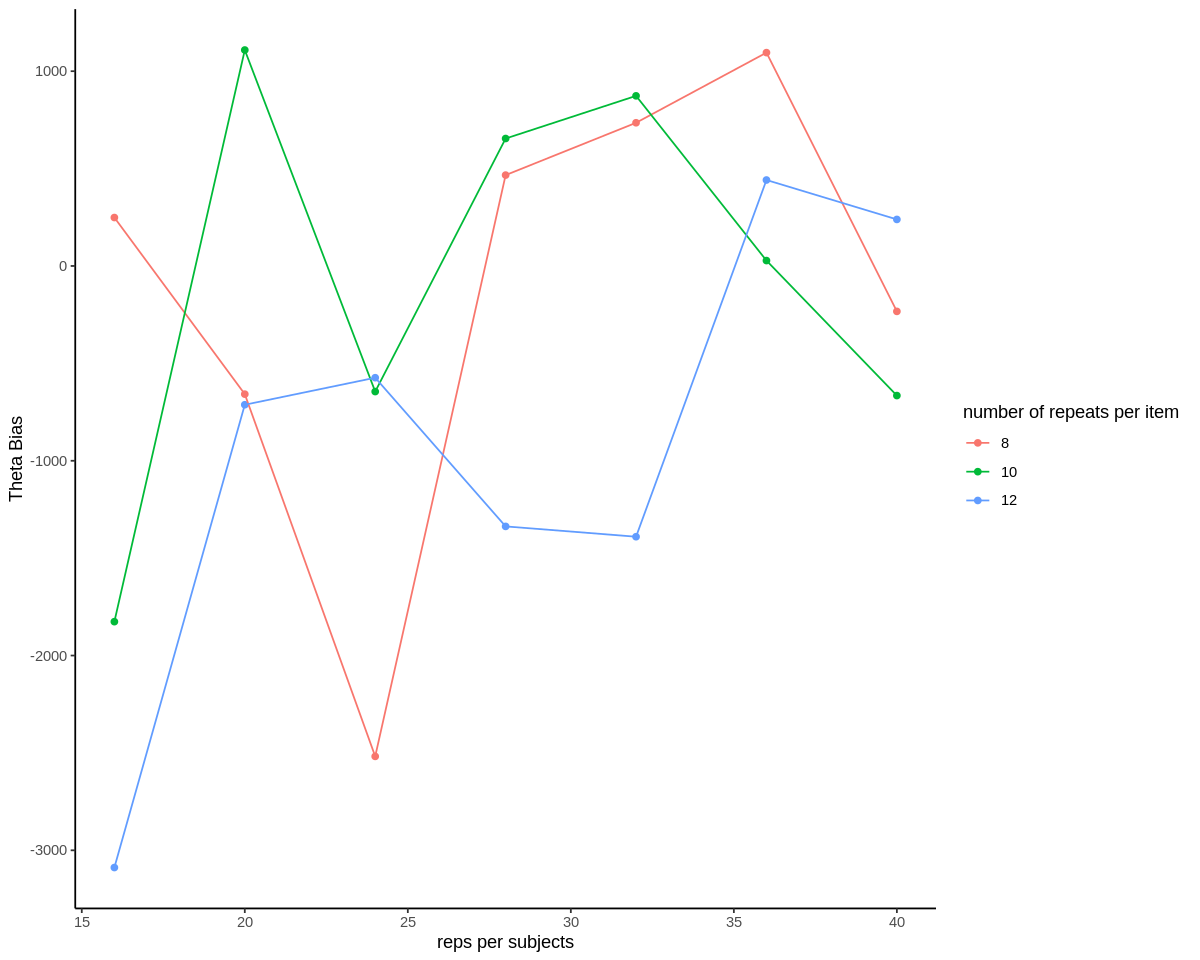

In [17]:
options(repr.plot.width=10, repr.plot.height=8)
ggplot(results, aes(n_subjects*2, power, color=as.factor(trials_per_item), group=trials_per_item)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept = 0.8) + # again, thresholds for acceptable power
    geom_hline(yintercept = 0.95) +
    scale_color_discrete('number of repeats per item') +
    scale_x_continuous('Number of subjects') +
    scale_y_continuous('Statistical power (for Delta BIC <= -20)') +
    theme_classic()


ggplot(results, aes(n_subjects*2, sigma_bias, color=as.factor(trials_per_item), group=trials_per_item)) +
    geom_point() +
    geom_line() +
    scale_color_discrete('number of repeats per item') +
    scale_x_continuous('Number of subjects') +
    scale_y_continuous('Sigma Bias') +
    theme_classic()

ggplot(results, aes(n_subjects*2, theta_bias, color=as.factor(trials_per_item), group=trials_per_item)) +
    geom_point() +
    geom_line() +
    scale_color_discrete('number of repeats per item') +
    scale_x_continuous('reps per subjects') +
    scale_y_continuous('Theta Bias') +
    theme_classic()

Pulling in the data from the actual analysis.

In [20]:
list.files()



test_data<-read.csv("test_data.csv")
combined_train_data<-read.csv("combined_train_data.csv")
combined_et_data<-read.csv("combined_et_data.csv")


[1] 5